In [101]:
%pylab inline
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [102]:
# Were results based on stranded info?

In [103]:
factors = ['BHLHE40','CEBPB','CTCF','E2F4','EBF1','ELF1','ELK1','ETS1','FOS','IRF4','JunD','Max','MEF2A','MEF2C','Mxi1','NFIC','NFKB','NFYA','NFYB','Nrf1','NRSF','PAX5','PBX3','POU2F2','PU1','RFX5','RUNX3','SP1','SRF','STAT1','STAT3','TCF3','USF1','USF2','YY1','ZBTB33','ZEB1','Znf143']
scorecols = ["Score_%s"%f for f in factors]
pcols = ["pval_%s"%f for f in factors]
orcols = ["OR_%s"%f for f in factors]
MAXSCORE = 1000

def maxabs(x):
    return max(abs(x))

def LoadKmer(fpath):
    max_kmers = [] # keep track of best kmers for each factor
    fdata = pd.read_csv(fpath%factors[0], sep="\t", usecols=[0,1,2], names=["kmer","pval_%s"%factors[0],"OR_%s"%factors[0]])
    fdata["Score_%s"%factors[0]] = np.log2(fdata["OR_%s"%factors[0]])*-1*np.log10(fdata["pval_%s"%factors[0]])
    # Fix
    fdata.ix[fdata["Score_%s"%factors[0]]<0, "Score_%s"%factors[0]] = 0
    fdata.ix[np.isnan(fdata["Score_%s"%factors[0]]), "Score_%s"%factors[0]] = 0
    fdata.ix[fdata["Score_%s"%factors[0]]==float("inf"), "Score_%s"%factors[0]] = MAXSCORE

    max_kmers.append(fdata.sort_values("Score_%s"%factors[0], ascending=False)["kmer"].values[0])
    for i in range(1, len(factors)):
        ff = pd.read_csv(fpath%factors[i], sep="\t", usecols=[0,1,2], names=["kmer","pval_%s"%factors[i],"OR_%s"%factors[i]])
        ff["Score_%s"%factors[i]] = np.log2(ff["OR_%s"%factors[i]])*-1*np.log10(ff["pval_%s"%factors[i]])
        ff.ix[ff["Score_%s"%factors[i]]<0, "Score_%s"%factors[i]] = 0
        ff.ix[ff["Score_%s"%factors[i]]==float("inf"), "Score_%s"%factors[i]] = MAXSCORE
        ff.ix[np.isnan(ff["Score_%s"%factors[i]]), "Score_%s"%factors[i]] = 0
        fdata = pd.merge(ff, fdata, on=["kmer"], how="right")
        max_kmers.append(fdata.sort_values("Score_%s"%factors[i], ascending=False)["kmer"].values[0])
    max_kmers = set(max_kmers)
    ORdata = fdata[["kmer"]+scorecols+orcols+pcols]
    ORdata.index = ORdata["kmer"]
    ORdata["maxscore"] = ORdata[orcols].apply(maxabs, 1) # sort by OR? or score?
    ORdata = ORdata.sort_values("maxscore", ascending=False)
    max_kmers = max_kmers.union(set(ORdata["kmer"][1:100])) # Use top 100 kmers
    return ORdata[["kmer"]+scorecols+orcols+pcols], max_kmers

In [104]:
fpath = "/storage/pandaman/project/AgentBind-GM12878-analysis/results/c/%s+GM12878/kmer_ranking.txt"
ORdata, max_kmers = LoadKmer(fpath)

fpath_good = "/storage/pandaman/project/AgentBind-GM12878-analysis/results-pval-less-05/c/%s+GM12878/kmer_ranking.txt"
ORdata_good, max_kmers_good = LoadKmer(fpath_good)

fpath_bad = "/storage/pandaman/project/AgentBind-GM12878-analysis/results-pval-no-less-05/c/%s+GM12878/kmer_ranking.txt"
ORdata_bad, max_kmers_bad = LoadKmer(fpath_bad)

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/lib/python3.4/sit

/home/mgymrek/.local/lib/python3.4/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


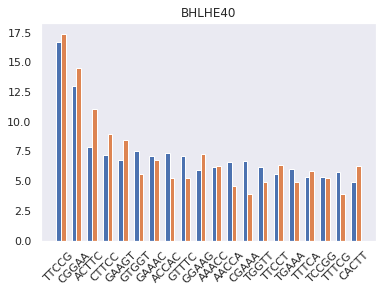

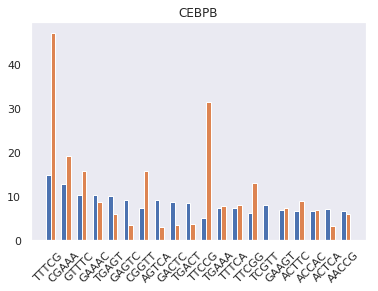

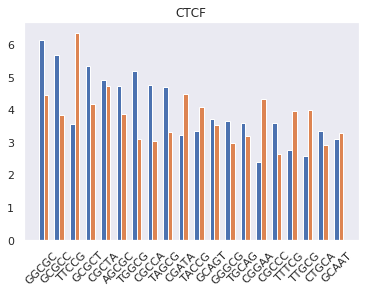

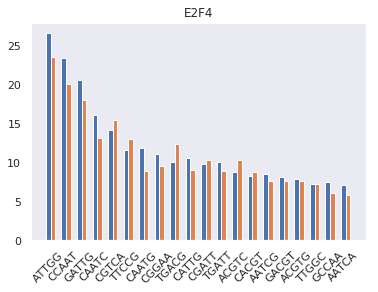

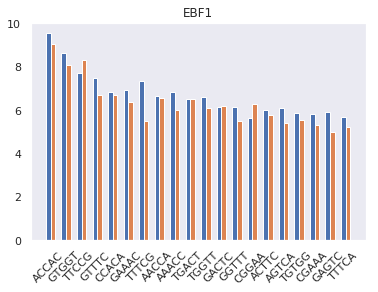

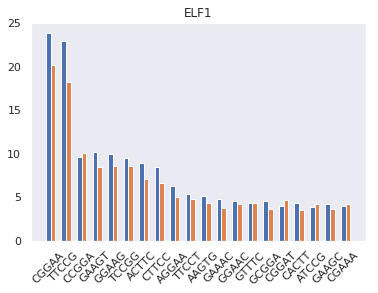

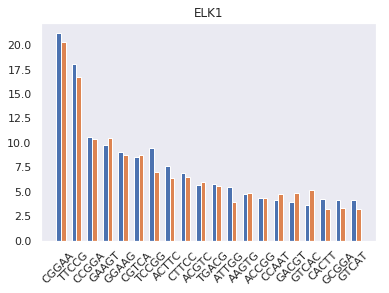

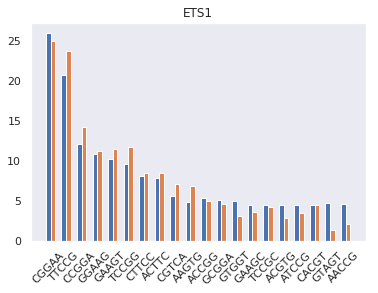

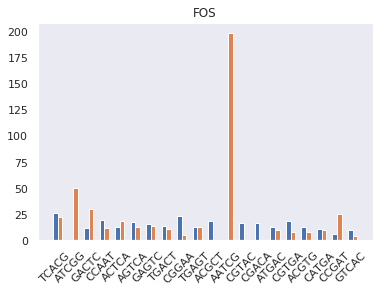

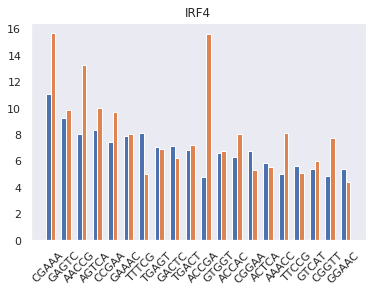

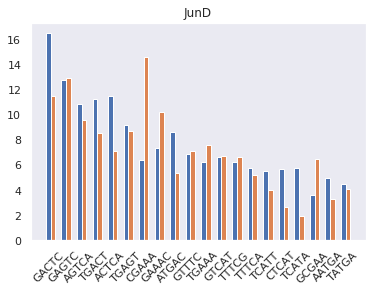

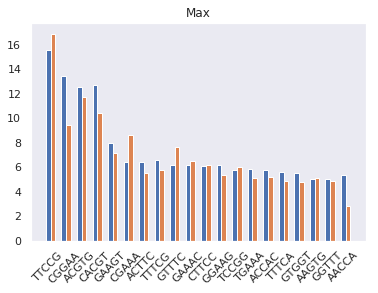

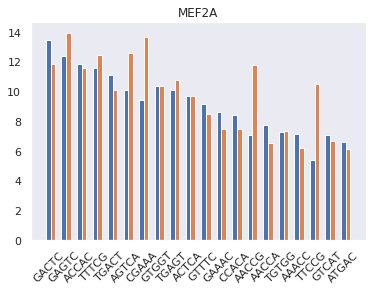

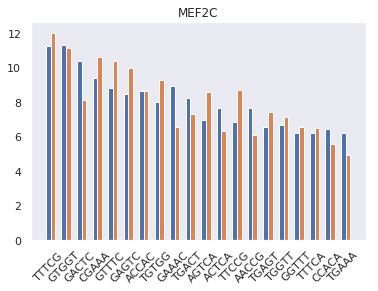

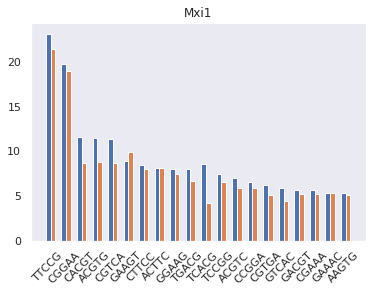

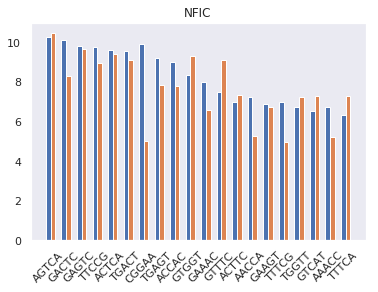

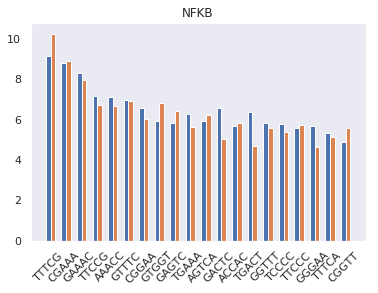

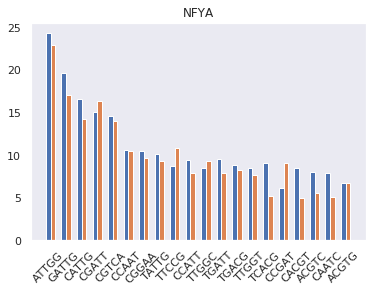

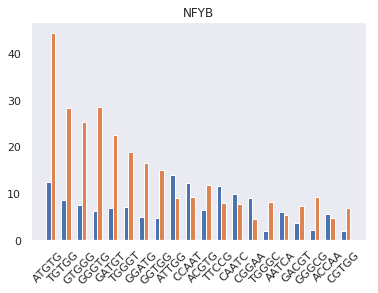

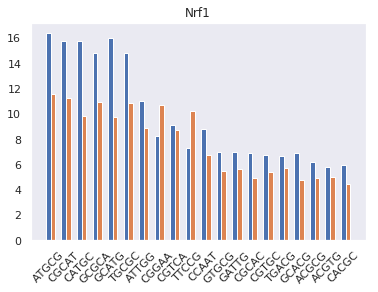

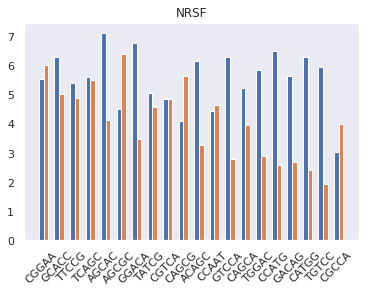

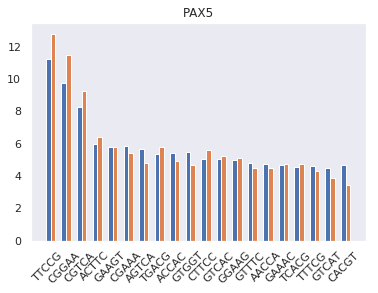

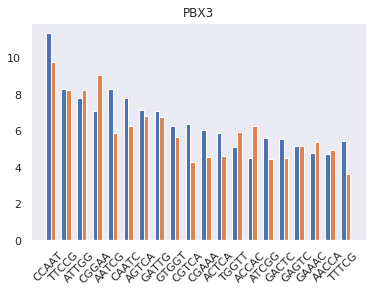

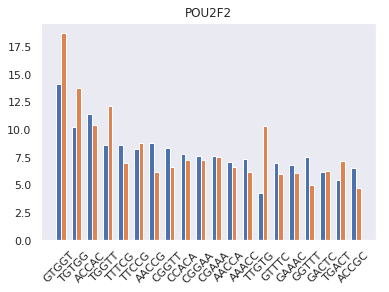

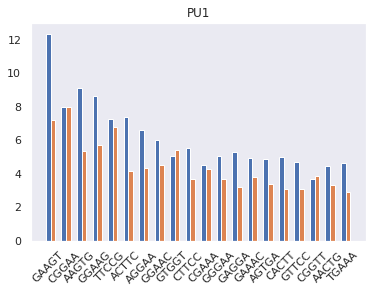

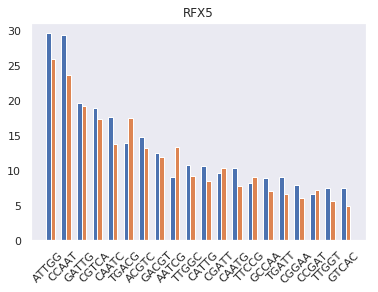

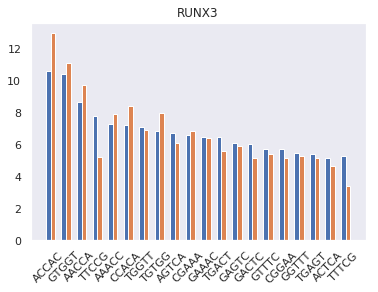

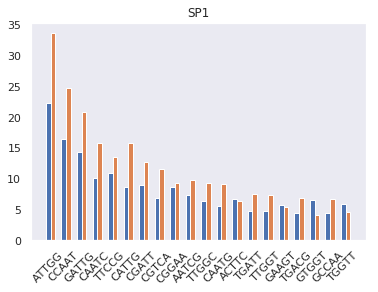

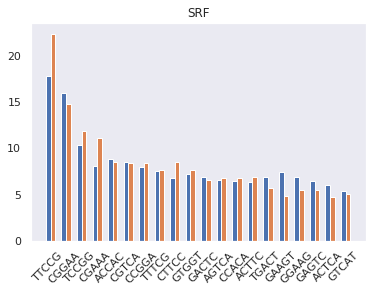

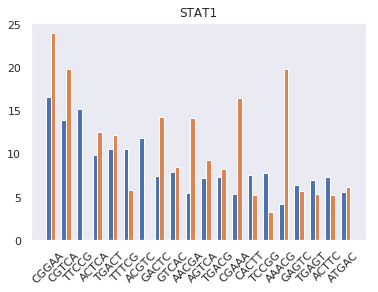

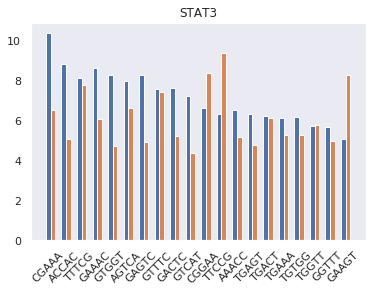

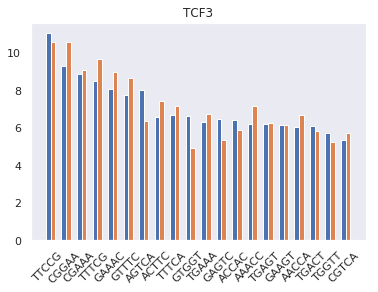

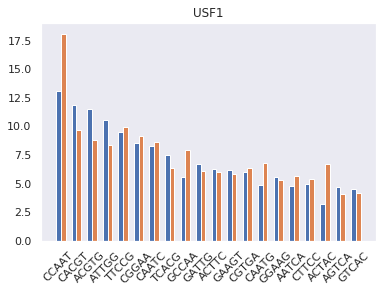

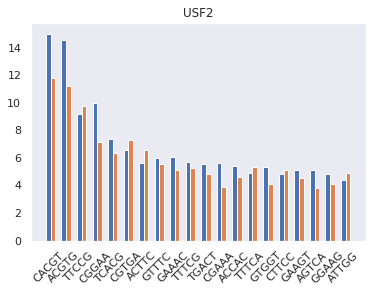

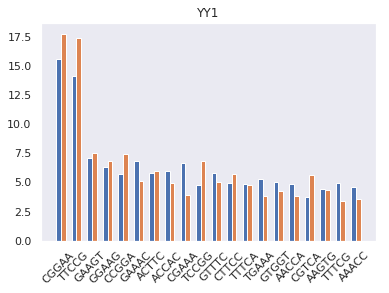

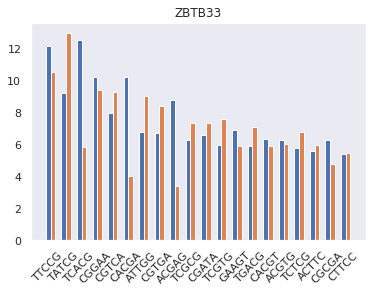

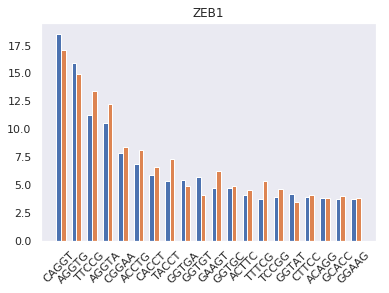

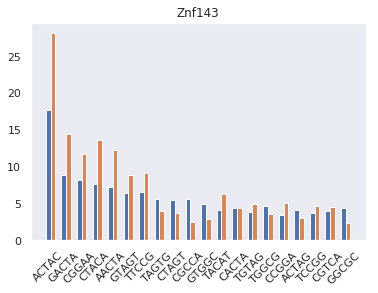

In [105]:
usecols = ["kmer"]+orcols
merged = pd.merge(pd.merge(ORdata_bad[usecols], ORdata_good[usecols], on=["kmer"], suffixes=("_bad","_good")), ORdata, on=["kmer"])

for factor in factors:
    xx = merged[["kmer","OR_%s_good"%factor,"OR_%s_bad"%factor,"OR_%s"%factor]]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xx = xx.sort_values("OR_%s"%factor, ascending=False).head(n=20)
    w = 0.3
    ax.bar(range(xx.shape[0]), xx["OR_%s_bad"%factor], width=w)
    ax.bar([item+w for item in range(xx.shape[0])], xx["OR_%s_good"%factor], width=w)
    ax.set_title(factor)
    ax.set_xticks(range(xx.shape[0]))
    ax.set_xticklabels(xx["kmer"], rotation=45)
    ax.grid(False)

In [106]:
!pwd

/storage/mgymrek/workspace/agent-bind-analyses/Figures


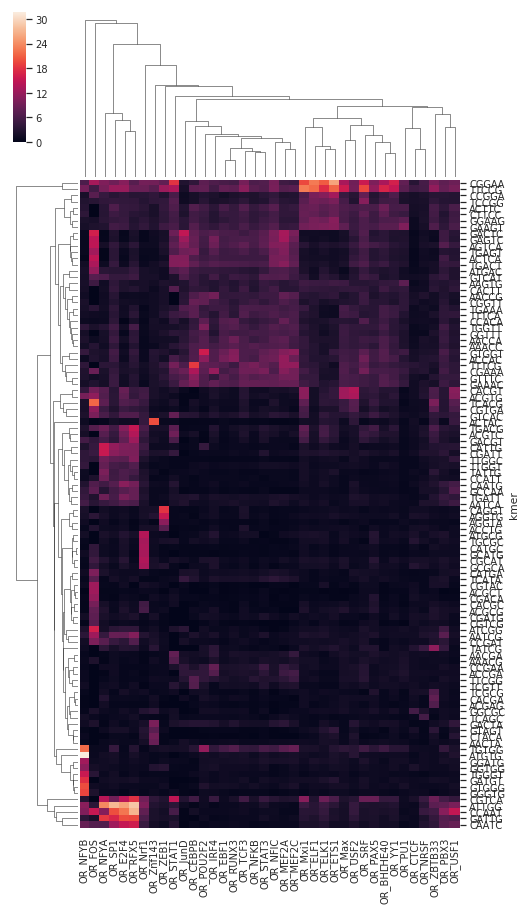

In [107]:
sns.set(font_scale=0.9)
g = sns.clustermap(ORdata[ORdata["kmer"].apply(lambda x: x in max_kmers)][orcols],
                   yticklabels=True, xticklabels=True, figsize=(8,15))
g.savefig("kmer_heatmap.pdf")

In [108]:
ORdata[["Score_STAT1","pval_STAT1","OR_STAT1"]]

,Score_STAT1,pval_STAT1,OR_STAT1
kmer,,,
ATGTG,0.000000,1.000000e+00,0.000000
ATTGG,3.537204,1.334956e-02,3.698598
CCAAT,9.069379,2.841493e-04,5.886089
CGGAA,82.337064,1.967392e-20,18.104177
TTCCG,48.971735,1.044857e-13,13.666641
TGTGG,0.556083,1.823180e-01,1.684484
TCACG,0.680962,2.422222e-01,2.152245
ACTAC,0.000000,6.521669e-01,0.951457
GTGGG,0.000000,9.864013e-01,0.231928
